In [2]:
# import library, which will be used in this project
import pandas as pd # import the pandas tool box
import numpy as np 	# import the numpy tool box
import matplotlib.pyplot as plt # import the matplotlib tool box 
from sklearn.metrics import mean_squared_error # import the sklearn tool box
from math import sqrt # import the math tool box
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt # import the statsmodels tool box
import statsmodels.api as sm # import the statsmodels tool box

In [3]:
# define a fucntion, in which will be used to aggregate hourly data into daliy averge data  
def Aggregating(x):
	x.Timestamp = pd.to_datetime(x.MarketHour) 
	x.index = x.Timestamp 
	return x.resample('D').mean()

In [4]:
# define a plot function, in which will be used to plot, train data, test data, and predicted data.
def draw(x,y,z,name):
	plt.plot(x, 'red', y, 'green', z, 'blue')
	plt.xlabel('Time')           # X-axis label
	plt.ylabel('Load')              # Y-axis label
	plt.title(name) # Overall title
	plt.legend(['train', 'test', 'predicted'], loc = 'best')
	plt.show()

In [8]:
# Importing data: SPP hourly load 2015/01/01-2018/05/31
df = pd.read_csv(r"C:\Users\bingqian hu\Desktop\Extracting data\train.csv") 

In [9]:
# Creating train dataset, which used to build the model and test dataset, which used to test the forecast performance 

train = df[0:26296]  # Choose data of from 2015/01/01 to 2017/12/31 as training dataset
test  = df[26297:]   # Choose data of from 2018/01/01 to 2018/05/31 as testing dataset

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


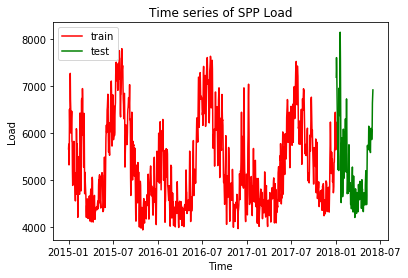

In [10]:
# Aggregating the dataset from hourly load into daily average load
train = Aggregating(train) #  
test  = Aggregating(test)  #

# plot the SPP load as daily average, in which the red line represent the trainning dataset and the green line represent the test dataset 
plt.plot(train, 'red', test, 'green')
plt.xlabel('Time')           # X-axis label
plt.ylabel('Load')              # Y-axis label
plt.title('Time series of SPP Load') # Overall title
plt.legend(['train', 'test'])
plt.show()

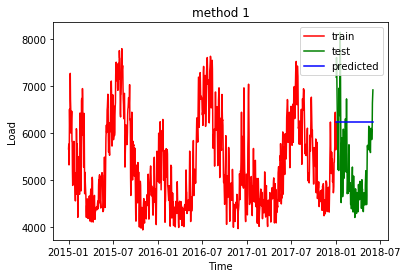

1220.8739765603468


In [14]:
# Method 1: Assume that the load of hour t, equals to the load of the next hour, t+1
# the equations could be represent by Load(the next time) = Load (the current time)
dd= np.asarray(train['CSWS'])
predicted1 = test.copy()
predicted1['CSWS'] = dd[len(dd)-1]

# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 1'
draw(train,test,predicted1,name)

# calculate the RMS of the method 1, and check the performance of method 1
rms_Method1 = sqrt(mean_squared_error(test['CSWS'], predicted1['CSWS']))
print("rms_Method1:",rms_Method1)

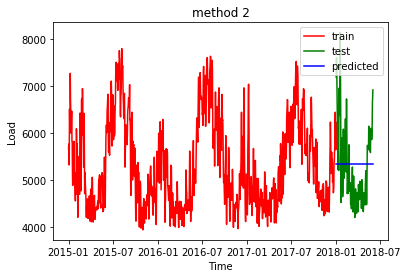

rms_Method2: 813.4602932480046


In [15]:
# Method 2: Simple Average, which assume that the load of the next time, equals to the average load of the past.
# the equations could be represent by Load(the next time) = average of the past Load.

predicted2 = test.copy()
a = np.asarray(train['CSWS'])
predicted2['CSWS'][0] = a.mean()

for i in range(test.shape[0]-1):	
	a = np.append(a,predicted2['CSWS'][i])
	predicted2['CSWS'][i+1] = a.mean()  
	
    
# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 2'
draw(train,test,predicted2,name)
rms_Method2 = sqrt(mean_squared_error(test['CSWS'], predicted2['CSWS']))
print("rms_Method2:",rms_Method2)

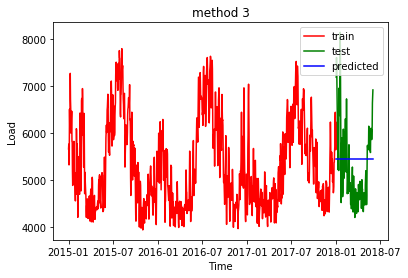

rms_Method3: 825.161904397315


In [16]:
# Method 3: Moving Average, which assume that the load of the next time, equals to the average load of the past pre-setting days.
# the equations could be represent by 
# Load(t) = [ Y(t-1) + Y(t-2) + ... + Y(t-p) ] / p

P = 20 # we setting 20 days.
predicted3 = test.copy()
predicted3['CSWS'] = train['CSWS'].rolling(P).mean().iloc[-1]

# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 3'
draw(train,test,predicted3,name)
rms_Method3 = sqrt(mean_squared_error(test['CSWS'], predicted3['CSWS']))
print("rms_Method3:",rms_Method3)

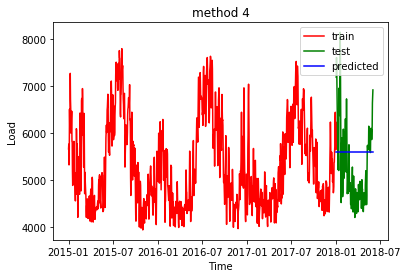

rms_Method4: 861.2004586195822


In [17]:
# Method 4: Simple Exponential Smoothing: use the Exponential function to traning the past load.
# the equations could be represent by 
# Load(t) = Exponential^(a*Load(t-1))
predicted4 = test.copy()
alpha = 0.1
fit = SimpleExpSmoothing(np.asarray(train['CSWS'])).fit(smoothing_level=alpha,optimized=False)
predicted4['CSWS'] = fit.forecast(len(test))

# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 4'
draw(train,test,predicted4,name)
rms_Method4 = sqrt(mean_squared_error(test['CSWS'], predicted4['CSWS']))
print("rms_Method4:",rms_Method4)

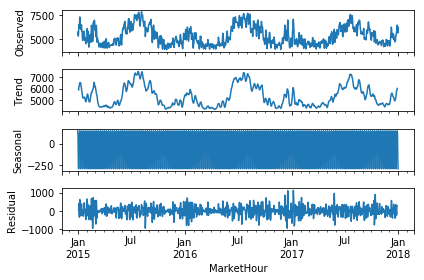

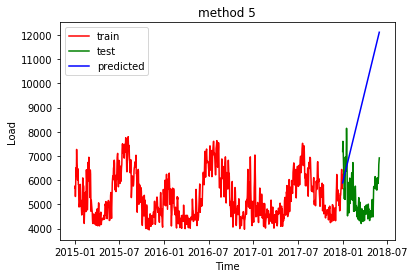

rms_Method5: 4273.238365112737


In [18]:
# Method 5: Holt,s Linear Trend method
sm.tsa.seasonal_decompose(train['CSWS']).plot()
result = sm.tsa.stattools.adfuller(train['CSWS'])
plt.show()
# Each Time series dataset can be decomposed into it,s componenets 
# which are Trend, Seasonality and Residual. 
# Any dataset that follows a trend can use Holt,s linear trend method for forecasting.

predicted5 = test.copy()
alpha = 0.1
lamda = 0.1
fit1 = Holt(np.asarray(train['CSWS'])).fit(smoothing_level = alpha,smoothing_slope = lamda)
predicted5['CSWS'] = fit1.forecast(len(test))

# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 5'
draw(train,test,predicted5,name)
rms_Method5 = sqrt(mean_squared_error(test['CSWS'], predicted5['CSWS']))
print("rms_Method5:",rms_Method5)

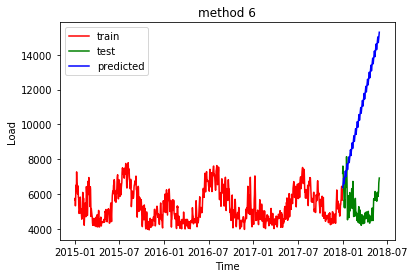

rms_Method6: 6194.222788209203


In [19]:
# Method 6: Holt Winters Method
predicted6 = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['CSWS']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
predicted6['CSWS'] = fit1.forecast(len(test))
# Using Holt’s winter method will be the best option among the rest of the models beacuse of the seasonality factor. 
# The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations: 
# one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.

# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 6'
draw(train,test,predicted6,name)
rms_Method6 = sqrt(mean_squared_error(test['CSWS'], predicted6['CSWS']))
print("rms_Method6:",rms_Method6)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


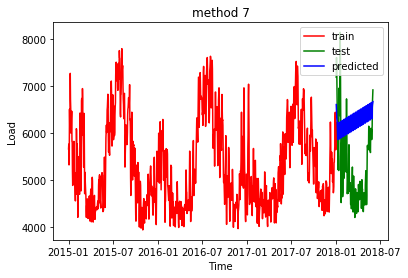

rms_Method7: 6194.222788209203


In [20]:
# Method 7: ARIMA:
# Autoregressive Integrated Moving average. 
# ARIMA models aim to describe the correlations in the data with each other. 
predicted7 = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train['CSWS'], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
predicted7['CSWS'] = fit1.predict(start="2018-1-1", end="2018-5-31", dynamic=True)

# plot the SPP load as daily average, 
# in which the red line represent the trainning dataset,
# the green line represent the test dataset, and the blue line represent the forecasted value 
name = 'method 7'
draw(train,test,predicted7,name)
rms_Method7 = sqrt(mean_squared_error(test['CSWS'], predicted6['CSWS']))
print("rms_Method7:",rms_Method7)